# Rotation curve MCMC notebook
4 Apr 2020

Note: when sharing this notebook, remember to include `functions.py`

In [169]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit

import emcee

import corner

In [32]:
## Constants ##
rsun = 8.34 # kpc (+- 0.16)
vsun = 240 # km/s (+- 8)
omegasun = vsun/rsun # km/s/kpc

degtorad = np.pi / 180

## Data set 1: inner solar disk

In the case of tangent points, the fundamental equation becomes:
$$V_R = R_t [\Omega - \Omega_\odot] = V_{cir} - \frac{V_\odot R_\odot \sin\ell}{R_\odot} = V_{cir} - V_\odot \sin\ell$$
$$V_{cir} = V_R + V_\odot \sin\ell$$

In [274]:
# x-axis
longs = np.array([73.58, 64.06, 57.07, 51.20, 46.22, 41.26, 36.84, 32.65, 28.66, 24.81, 21.08, 17.44, 13.88]) # deg
radii = rsun * np.sin(degtorad * longs) # kpc
# y-axis
vpeaks = np.array([3.9, 26.6, 46.14, 57.5, 60.7, 77.4, 89.1, 98.7, 106.5, 107.2, 123.6, 128.9, 151.74]) # km/s
v0s = np.array([12.7, 27.7, 52.2, 66.4, 68.9, 84.5, 95.5, 109.7, 115.4, 119.7, 127.5, 137.1, 157.07]) # km/s
vrs = (vpeaks + v0s)/2 # km/s
vcirs = vrs + vsun * np.sin(degtorad*longs)
# y-errs
basic_errs = (v0s - vpeaks)/2 # km/s
gashole_errs = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 10, 10]) # km/s
veldisp_err = 4.2 # km/s (Combes 1991)
vr_errs = np.sqrt(basic_errs**2 + gashole_errs**2 + veldisp_err**2)
vcir_errs = vr_errs

## Data set 2: masers

$$V_{cir} = R\left(\frac{V_R}{R_\odot \sin\ell} + \Omega_\odot\right)$$

In [275]:
# x-axis
maser_longs = np.array([75.29, 97.53, 135.27]) # deg
maser_parallaxes = np.array([0.108, 0.133, 0.167]) # milliarcsec
maser_parallax_errs = np.array([0.005, 0.017, 0.011]) # milliarcsec
maser_radii = np.sqrt(1/maser_parallaxes**2 + rsun**2 - 2*rsun/maser_parallaxes*np.cos(degtorad*maser_longs))
# y-axis
maser_vrs = [-55.51, -72.93, -71.98]
maser_vcirs = maser_radii * (maser_vrs / (rsun * np.sin(degtorad * maser_longs)) + omegasun)
# y-errs
maser_vr_errs = [5, 5, 5]
maser_vcir_errs = maser_vr_errs * maser_radii / (rsun * np.sin(degtorad * maser_longs))

## Data set 3: Mroz 2019 Cepheids
A couple systematic issues:
- Mroz et al. use a different value for $R_\odot$ and $V_\odot$ compared to what we were using
- Mroz et al. included x-axis error bars, which we're currently ignoring

In [276]:
mroz_data = np.loadtxt('survey_files/mroz_selection.txt')
mroz_radii, mroz_vcirs, mroz_vcir_errs = mroz_data[:,0], mroz_data[:,1], mroz_data[:,2]

## Data set 4: Chile data (low longitude solar disk)

In [277]:
# x-axis
chile_longs = np.array([10.375, 6.875, 3.5]) # deg
chile_radii = rsun * np.sin(degtorad*chile_longs) # 1.5, 1, .5 kpc
# y-axis
chile_vpeaks = np.array([172.9, 218.4, 263.9]) # km/s
chile_v0s = np.array([176.8, 226.8, 282.8])
chile_vrs = (chile_vpeaks + chile_v0s) / 2.
chile_vcirs = chile_vrs + vsun * np.sin(degtorad*chile_longs)
# y-err
chile_basic_errs = (chile_v0s - chile_vpeaks) / 2.
chile_gashole_errs = np.array([10,10,10])
veldisp_err = 4.2
chile_vr_errs = np.sqrt(chile_basic_errs**2 + chile_gashole_errs**2 + veldisp_err**2)
chile_vcir_errs = chile_vr_errs

## All data

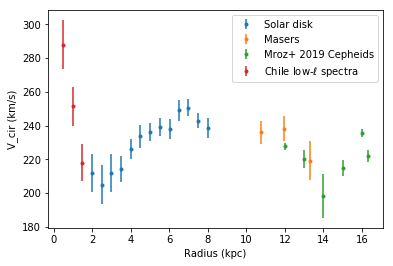

In [336]:
plt.errorbar(radii, vcirs, vcir_errs, fmt='.', label='Solar disk')
plt.errorbar(maser_radii, maser_vcirs, maser_vcir_errs, fmt='.', label='Masers')
plt.errorbar(mroz_radii, mroz_vcirs, mroz_vcir_errs, fmt='.', label='Mroz+ 2019 Cepheids')
plt.errorbar(chile_radii, chile_vcirs, chile_vcir_errs, fmt='.', label='Chile low-$\\ell$ spectra')
plt.xlabel('Radius (kpc)')
plt.ylabel('V_cir (km/s)')
plt.legend()

In [337]:
all_radii = np.concatenate([chile_radii, radii, maser_radii, mroz_radii])
all_vs = np.concatenate([chile_vcirs, vcirs, maser_vcirs, mroz_vcirs])
all_verrs = np.concatenate([chile_vcir_errs, vcir_errs, maser_vcir_errs, mroz_vcir_errs])

## Simple curve fits

In [338]:
from functions import point_fit, uniform_fit, expdisk_fit, diskhalo_fit, bulgedisk_fit, total_fit

In [339]:
popt_point, _ = curve_fit(point_fit, all_radii, all_vs, sigma=all_verrs)
print(popt_point)

[7.96218012e+10]


In [340]:
popt_uniform, _ = curve_fit(uniform_fit, all_radii, all_vs, sigma=all_verrs)
print(popt_uniform)

[18293715.50786729]


In [341]:
popt_expdisk, _ = curve_fit(expdisk_fit, all_radii, all_vs, sigma=all_verrs)
print(popt_expdisk)

[-3.87441790e+00  6.63515539e+06]


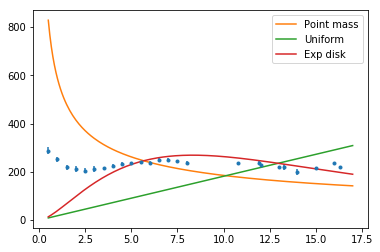

In [342]:
rs = np.linspace(.5, 17, 200)
plt.errorbar(all_radii, all_vs, all_verrs, fmt='.')
plt.plot(rs, point_fit(rs, *popt_point), label='Point mass')
plt.plot(rs, uniform_fit(rs, *popt_uniform), label='Uniform')
plt.plot(rs, expdisk_fit(rs, *popt_expdisk), label='Exp disk')
plt.legend()

In [343]:
popt_bulgedisk, _ = curve_fit(bulgedisk_fit, all_radii[:16], all_vs[:16], sigma=all_verrs[:16], p0=[.2, 2e10, 4, 1e7])
print(popt_bulgedisk)

[2.19744769e-01 2.04320332e+10 3.48454407e+00 6.04202821e+06]


In [345]:
# plt.errorbar(all_radii, all_vs, all_verrs, fmt='.')
# plt.plot(rs, bulgedisk_fit(rs, *popt_bulgedisk), label='Bulge + Disk (fit to inner disk only)')
# plt.legend()

In [346]:
popt_diskhalo, _ = curve_fit(diskhalo_fit, all_radii[3:], all_vs[3:], sigma=all_verrs[3:], p0=[4,  7e7,  .5, 4e9])
print(popt_diskhalo)

[-2.65363027e+00  4.29948327e+06  2.46308270e-01  1.51492199e+10]


In [349]:
popt_total, _ = curve_fit(total_fit, all_radii, all_vs, sigma=all_verrs, p0=[.2, 2e10, 4,  7e6,  .5, 4e9])
print(popt_total)

[-2.43301130e-01  2.15275331e+10  3.58207168e+00  5.84509441e+06
  2.96453621e+02  5.27043313e+09]


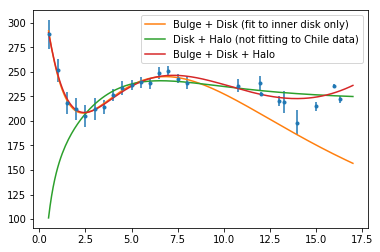

In [363]:
rs = np.linspace(.5, 17, 200)
plt.errorbar(all_radii, all_vs, all_verrs, fmt='.')
plt.plot(rs, bulgedisk_fit(rs, *popt_bulgedisk), label='Bulge + Disk (fit to inner disk only)')
plt.plot(rs, diskhalo_fit(rs, *popt_diskhalo), label='Disk + Halo (not fitting to Chile data)')
plt.plot(rs, total_fit(rs, *popt_total), label='Bulge + Disk + Halo')
plt.legend()

## MCMC
We've been messing around with different models and different subsets of the data. Some of these converge and some do not. We haven't kept track of everything we tried, but for example:
- Exponential disk on just the original solar disk data set does not converge
- Exponential disk on the original solar disk + masers + Mroz cepheids does converge
- Bulge + disk on the total data set converge
- Bulge + disk + halo on the total set do not converge

In [402]:
mcmc_radii = all_radii
mcmc_vs = all_vs
mcmc_verrs = all_verrs

def log_prob(x):
    vfits = np.array([bulgedisk_fit(r, *x) for r in mcmc_radii])
    lprob = np.sum(-(vfits - mcmc_vs)**2/(2*mcmc_verrs**2))
    
    if lprob != lprob:
        #print('nan!, x=',x)
        return -np.inf
    return lprob

In [403]:
ndim = 4
nwalkers = 2*ndim

In [404]:
popt_cheat = popt_bulgedisk

In [405]:
p0 = np.array([popt_cheat for _ in range(nwalkers)]) + 0.01 * np.random.randn(nwalkers, ndim)

In [406]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob)
state = sampler.run_mcmc(p0, 5000)

In [388]:
state2 = sampler.run_mcmc(state, 15000)

In [ ]:
state3 = sampler.run_mcmc(state2, 45000)

dim 0


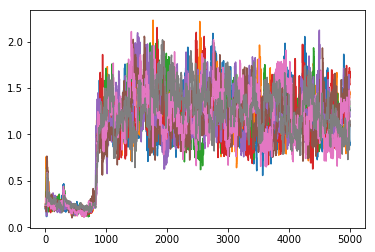

dim 1


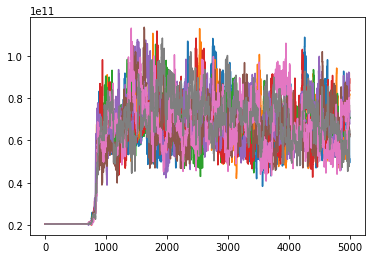

dim 2


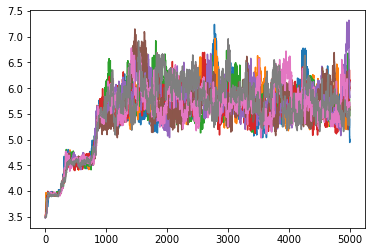

dim 3


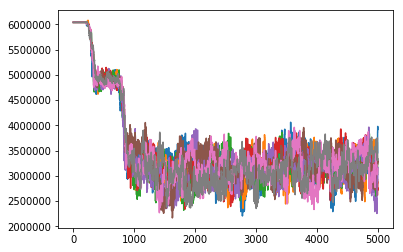

In [407]:
chain = sampler.get_chain()
for dim in range(ndim):
    print('dim', dim)
    for walker in range(nwalkers):
        plt.plot(abs(chain[:,walker,dim]))
    plt.show()

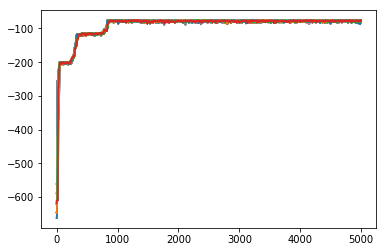

In [408]:
for walker in range(nwalkers):
    plt.plot(sampler.get_log_prob())
#plt.ylim(-100,0)

In [409]:
chain.shape

(5000, 8, 4)

In [410]:
burnin = -2000
chain_flat = chain[burnin:].reshape(-1,ndim)

Text(0.5, 1.0, 'MCMC for bulge+disk fit')

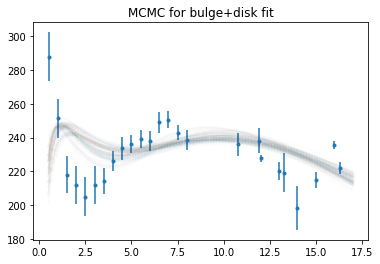

In [413]:
## Plot MCMC final curves ##
rs = np.linspace(.5, 17, 200)
plt.errorbar(mcmc_radii, mcmc_vs, mcmc_verrs, fmt='.')
#plt.plot(rs, expdisk_fit(rs, *p0[2])) <- initial
for popt in chain_flat[-100:]:
    plt.plot(rs, bulgedisk_fit(rs, *popt), alpha=.01)
plt.title('MCMC for bulge+disk fit')
#plt.ylim(0,400)

## Testing weird numerical stuff from halo fit
When we try running MCMC with a bulge + disk + halo model, we get decently good fits, and the bulge and disk parameters converge, but the halo parameters start growing uncontrollably. It creates a weird bumpy pattern in what should be a smooth curve (see plot below).

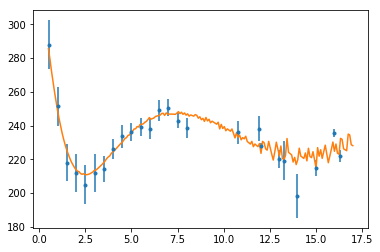

In [433]:
# weird numerical stuff starts happening
plt.errorbar(mcmc_radii, mcmc_vs, mcmc_verrs, fmt='.')
plt.plot(rs, total_fit(rs, *[-2.83e-1, 2.32e10, 3.65, 5.74e6, 2.01e8, 2.11e21]))

In [430]:
from functions import halo_fit

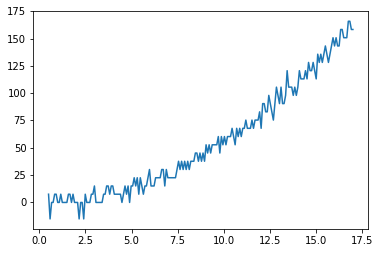

In [431]:
plt.plot(rs, halo_fit(rs, *[2.01e8, 2.11e21]))

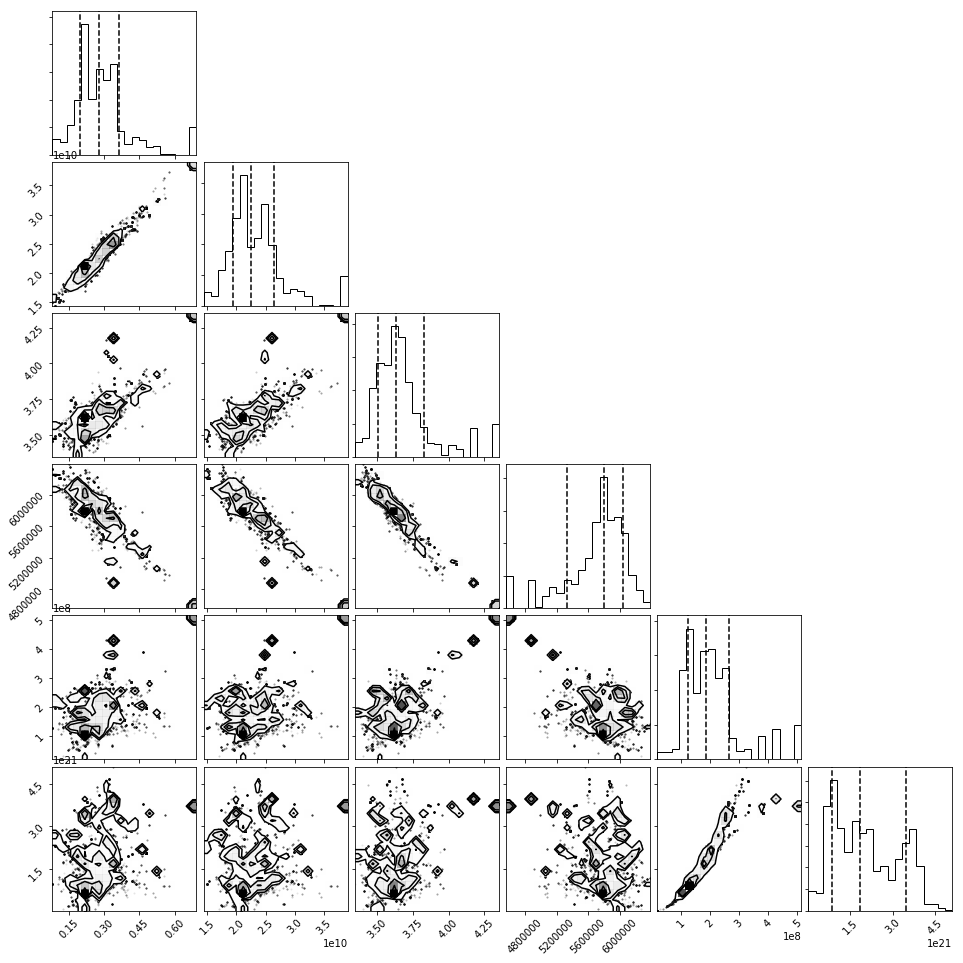

In [394]:
corner.corner(abs(chain_flat), 
              #labels=['rd', 'sig0', 'rh', 'rhoh'],
              quantiles=[0.16, 0.5, 0.84],
              show_titles=False)
plt.show()